# Ecommerce Dataset Analysis using SQL

In [ ]:
import pandas as pd
import mysql.connector
import numpy as np
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling

]
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Aksh@y_mysql',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/aksha/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Aksh@y_mysql',
    database='ecommerce'
)
cur= db.cursor()


# List all unique cities where customers are located.


In [8]:
query="""select distinct customer_city FROM ecommerce.customers """

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [10]:
query="""select count(order_id) FROM orders
where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data=cur.fetchall()

print("Total orders placed in 2017 are" ,data[0][0])

Total orders placed in 2017 are 45101


# Find the total sales per category.

In [12]:


query="""select product_category,
round(sum(payment_value),2) as total_sales
from products JOIN
order_items on products.product_id=order_items.product_id
join payments on
order_items.order_id=payments.order_id
group by product_category
order by 2 desc; """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["Category","Sales"])
df.head()

,Category,Sales
0,bed table bath,1712553.67
1,HEALTH BEAUTY,1657373.12
2,computer accessories,1585330.45
3,Furniture Decoration,1430176.39
4,Watches present,1429216.68


# Calculate the percentage of orders that were paid in installments.

In [15]:

query="""SELECT (sum(case
when payment_installments>=1 then true
else false
end))/count(*)*100
from payments; """

cur.execute(query)

data=cur.fetchall()
print("The percentage of orders that were paid in installments is",(data[0][0]))

The percentage of orders that were paid in installments is 99.9981


# Count the number of customers from each state.

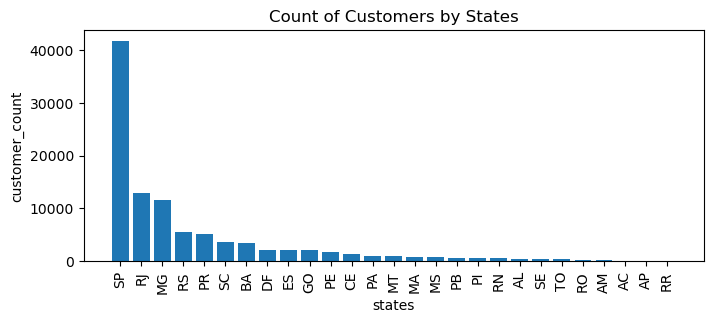

In [19]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018

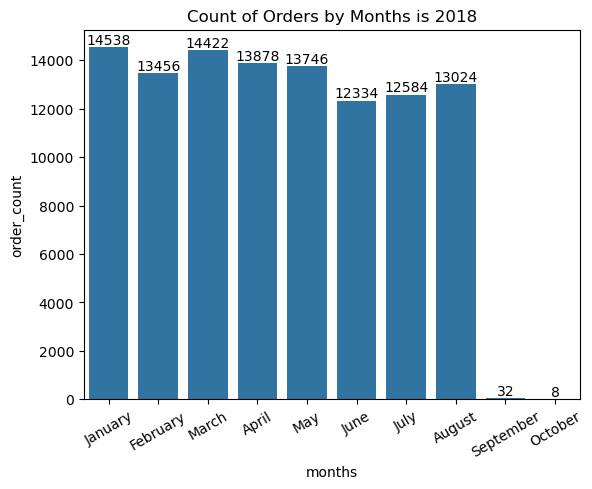

In [73]:
query = """ 
SELECT 
MONTHNAME(order_purchase_timestamp),
    COUNT(order_id)
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTHNAME(order_purchase_timestamp) 
ORDER BY MONTHNAME(order_purchase_timestamp) ;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]
plt.xticks(rotation = 30)
ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [52]:
query = """ 
with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_City", "Average Products per order"])
df.head(10)

,Customer_City,Average Products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [57]:
query = """ 
select products.product_category,round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as percentage from products
join order_items on order_items.product_id=products.product_id
join payments on payments.order_id=order_items.order_id
group by products.product_category order by percentage desc;

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Percentage"])
df.head(10)

,Category,Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# Identify the correlation between product price and the number of times a product has been purchased

In [85]:

query = """ 
select products.product_category, 
count(order_items.product_id) as order_count,
round(avg(order_items.price),2) as price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", a[0][-1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


#  Calculate the total revenue generated by each seller, and rank them by revenue.

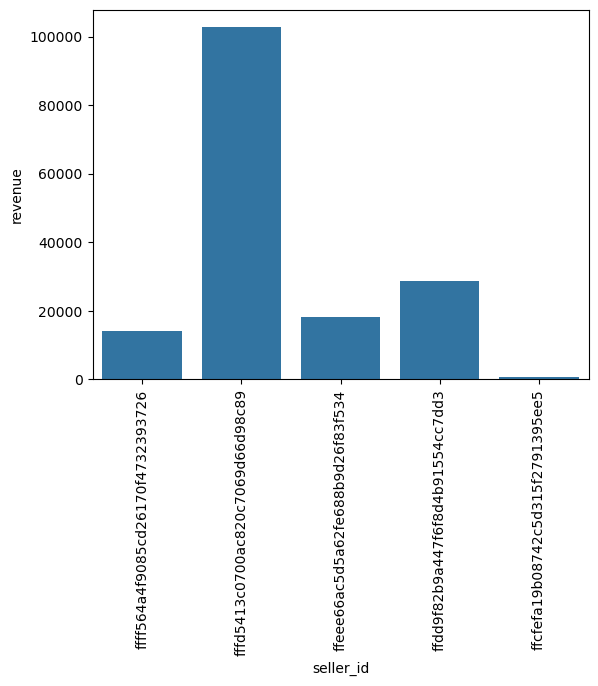

In [13]:


query = """ 
select sellers.seller_id, sum(payments.payment_value) as revenue,
rank() over (order by sellers.seller_id desc) as rnk from sellers join order_items on
sellers.seller_id=order_items.seller_id
join payments on payments.order_id=order_items.order_id
group by sellers.seller_id
order by 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df, legend= True)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [21]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [26]:
query = """select years, months , payment, sum(payment)
over(partition by years order by years,months) as cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["years","months","payment","cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,553952.16
4,2017,2,1167632.04,1721584.20
5,2017,3,1799454.40,3521038.60
6,2017,4,1671152.12,5192190.72
7,2017,5,2371675.28,7563866.00
8,2017,6,2045105.52,9608971.52
9,2017,7,2369531.68,11978503.20


# Calculate the year-over-year growth rate of total sales

In [32]:
query = """select years, round(((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100,2) as YOY_Percent_Growth from
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Years","YOY_Percent_Growth"])
df

,Years,YOY_Percent_Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [41]:
query = """with a as(select customers.customer_id,min(orders.order_purchase_timestamp) as first_order from customers
join orders on customers.customer_id=orders.customer_id
GROUP BY customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) from a join orders on
a.customer_id=orders.customer_id and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) as Retention_rate
from a left join b 
on a.customer_id = b.customer_id ;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Retention_rate"])
df

,Retention_rate
0,None


In [45]:
# Retention Rate is showing as none as there is no customer in the dataset eligible that met the retention criteria

# Identify the top 3 customers who spent the most money in each year

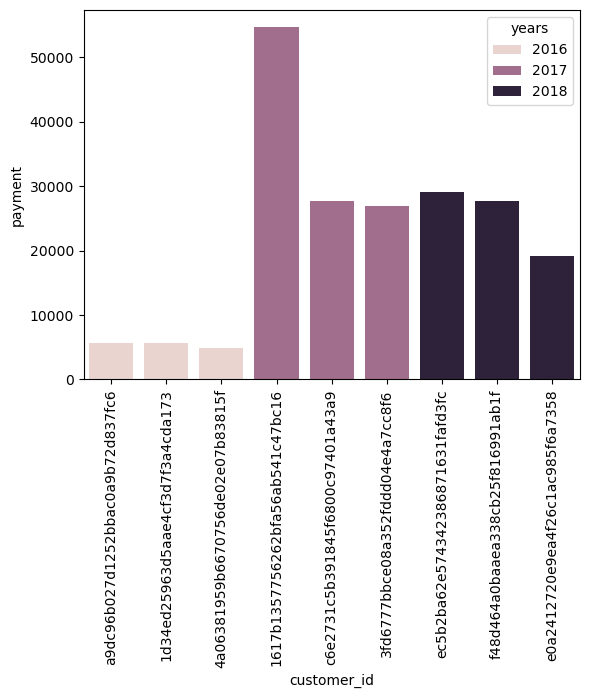

In [52]:


query = """select years, customer_id, payment, RNK from(select year(orders.order_purchase_timestamp) as years, orders.customer_id, sum(payments.payment_value) as payment,
rank() over(partition by year(orders.order_purchase_timestamp) ORDER BY sum(payments.payment_value) desc) as RNK
from orders join payments on 
orders.order_id=payments.order_id group by year(orders.order_purchase_timestamp), orders.customer_id) as a where RNK <= 3;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","customer_id","payment","RNK"])
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()

#                              End of the Project